### Import and register model

In [1]:
from ray.rllib.contrib.alpha_zero.core.alpha_zero_trainer import AlphaZeroTrainer
from ray.rllib.policy.sample_batch import DEFAULT_POLICY_ID
from ray.rllib.policy.policy_map import PolicyMap
from ray.rllib.evaluation.episode import Episode
from ray.rllib.models.catalog import ModelCatalog
import numpy as np

from parameters import parameters

ModelCatalog.register_custom_model("model", parameters["model"])

In [2]:
checkpoint_path = "exps/AlphaZero_Connect4/contrib_AlphaZero_Connect4_738fd_00000_0_2022-05-15_00-16-09/checkpoint_000100/checkpoint-100"

### Evaluation parameters

In [3]:
parameters["config"]["mcts_config"]["num_simulations"] = 1000
parameters["config"]["mcts_config"]["argmax_tree_policy"] = True
parameters["config"]["mcts_config"]["add_dirichlet_noise"] = False
parameters["config"]["mcts_config"]["temperature"] = 1

### Load the agent

In [4]:
agent = AlphaZeroTrainer(env=parameters["env"], config=parameters["config"])
agent.restore(checkpoint_path)
policy = agent.get_policy()

env = parameters["env"]()

2022-05-16 19:58:45,161	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-05-16 19:58:51,546	WARNING util.py:60 -- Install gputil for GPU system monitoring.
2022-05-16 19:58:51,557	INFO trainable.py:534 -- Restored on 127.0.0.1 from checkpoint: exps/AlphaZero_Connect4/contrib_AlphaZero_Connect4_738fd_00000_0_2022-05-15_00-16-09/checkpoint_000100/checkpoint-100
2022-05-16 19:58:51,558	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': 115186, '_time_total': 96544.52640390396, '_episodes_total': 3766}


### Test the agent

- If `use_model_only` is `True`, the actions are chosen using only the policy network
- If `vs_human` is `True`, you can play vs the agent by entering a valid action

(RolloutWorker pid=6613) 2022-05-16 19:58:51,506	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=6613) 2022-05-16 19:58:51,506	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=6614) 2022-05-16 19:58:51,541	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrect

3


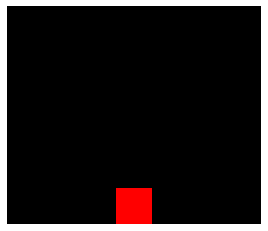

3


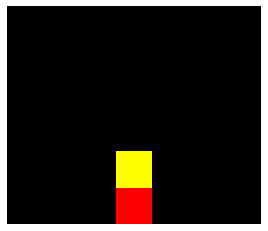

4


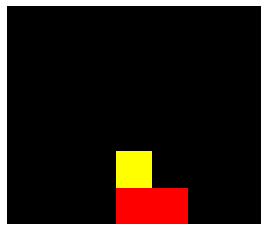

2


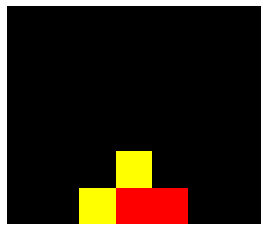

5


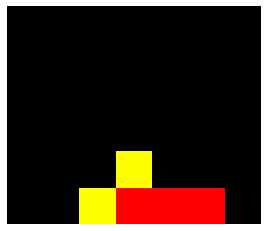

6


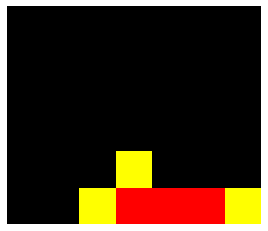

4


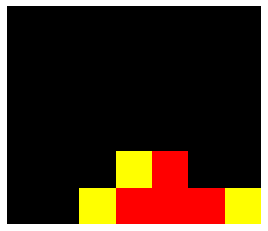

4


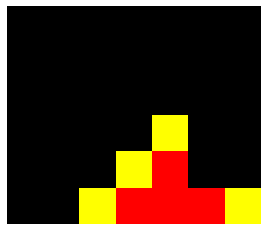

2


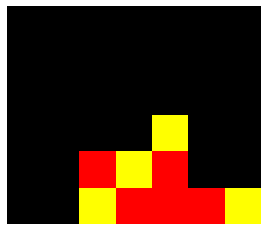

5


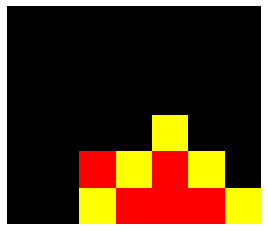

2


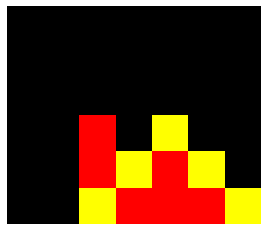

5


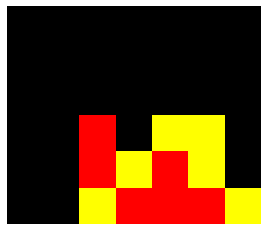

5


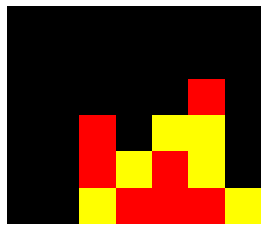

3


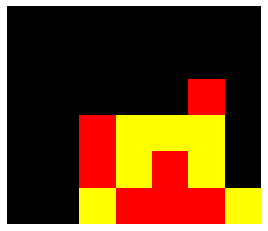

3


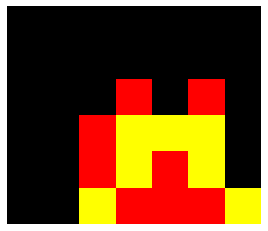

6


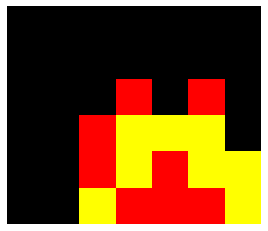

6


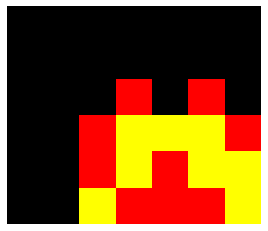

4


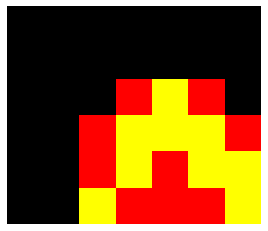

3


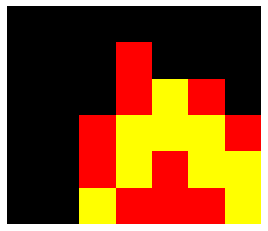

4


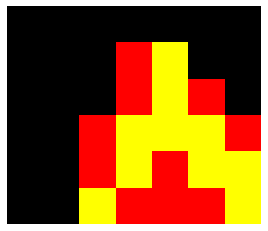

4


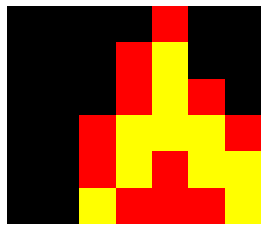

2


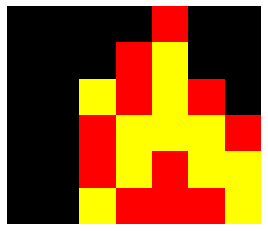

2


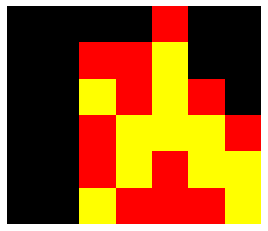

5


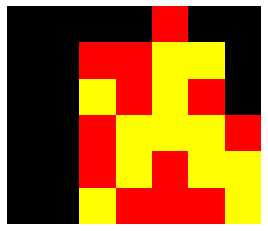

0


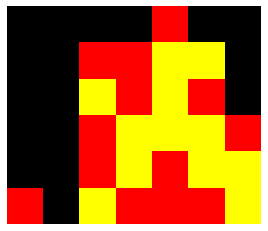

6


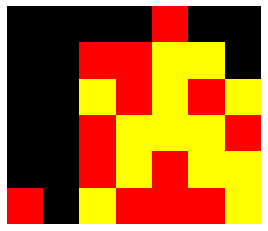

5


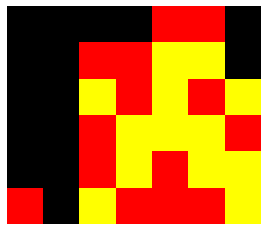

3


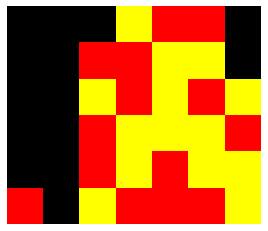

2


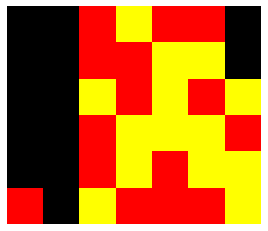

0


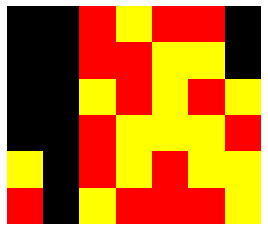

1


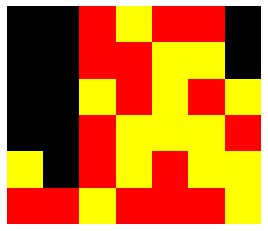

1


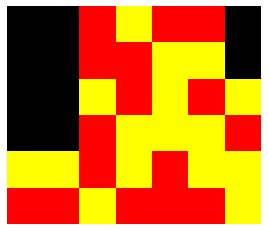

1


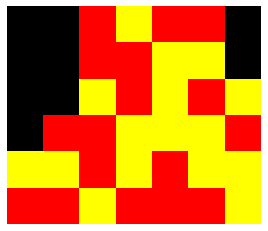

1


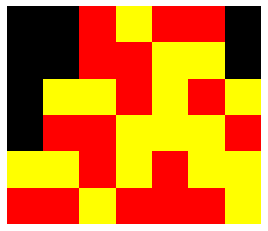

1


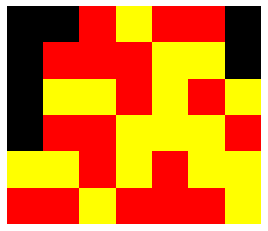

6


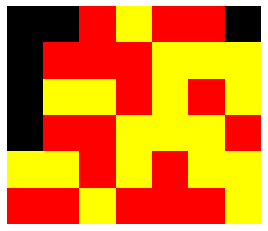

6


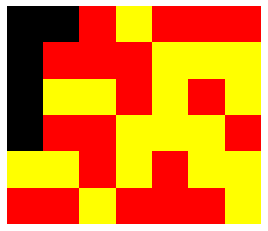

1


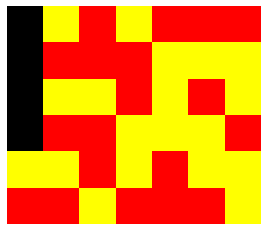

0


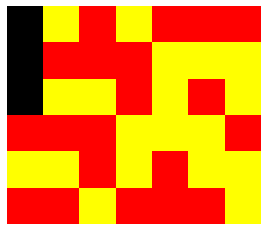

0


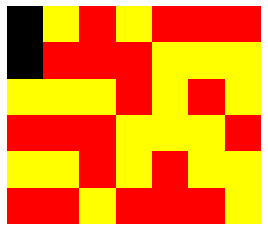

0


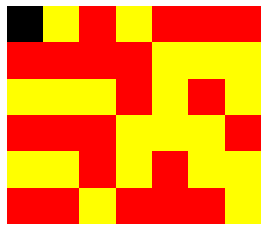

In [5]:
obs = env.reset()

episode = Episode(
    PolicyMap(0,0),
    lambda _, __: DEFAULT_POLICY_ID,
    lambda: None,
    lambda _: None,
    0,
)

use_model_only = False
vs_human = False

count = 0
done = False
while not done:
  episode.user_data['initial_state'] = env.get_state()
  if count % 2 == 0 or not vs_human:
    if use_model_only:
      obs["obs"] = torch.from_numpy(obs["obs"]).float()
      valid_action = obs["action_mask"].astype(bool)
      action = policy.model.forward(obs, None, None)[0]
      action[~valid_action] = -np.inf
      action = torch.argmax(action).item()
    else:
      action, _, _ = policy.compute_single_action(obs, episode=episode)
  else:
    action = int(input("Type a valid action:"))
  print(action)
  obs, reward, done, _ = env.step(action)
  env.render()
  #episode.length += 1
  count += 1

### Test the policy network

In [8]:
import torch

obs = env.reset()
env.step(3)
env.step(3)
env.step(3)
env.step(3)
env.step(3)
env.step(3)
env.step(4)
env.step(5)
env.step(1)
env.step(2)
env.step(2)
obs, _, _, _ = env.step(2)
obs["obs"] = torch.from_numpy(obs["obs"]).float()

policy.model.forward(obs, None, None)[0], policy.model.value_function()

(tensor([ 0.0920,  0.0005, -0.0050,  0.1604,  0.1100, -0.0384, -0.2650],
        grad_fn=<AddBackward0>),
 tensor([0.0201], grad_fn=<AddBackward0>))